<img src="https://github.com/Kesterchia/Institute-of-Data/blob/master/Project%202/Images/Kickstarter-Celebrates-10-Years-of-Funding.jpg?raw=true" width="420" height="420"> 

# About the Kickstarter dataset:


### Source

Data obtained from: https://www.kaggle.com/kemical/kickstarter-projects?select=ks-projects-201801.csv


### Content

This dataset contains about 400,000 rows of data collected on crowdfunding projects hosted on Kickstarter.com.


Columns are self explanatory except:

usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).

usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).

usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).

### Acknowledgements

Data are collected from Kickstarter Platform

usd conversion (usdpledgedreal and usdgoalreal columns) were generated from convert ks pledges to usd script done by tonyplaysguitar

# Problem statement: 

## Can i predict how many backers I would need to have a successful project?

This project aims to deliver some insights into how much support from backers a kickstarter project would need to have a decent chance of success. 

Kickstarter.com is a crowdfunding platform that provides entrepreneurs with an alternative to traditional bank loans. 

In [1]:
#Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import category_encoders as ce

import joblib

%matplotlib inline



In [2]:
#Read in data (CSV)

df = pd.read_csv('ks-projects-201801.csv', index_col = 'ID')

#Note: Remember to read in ID as the index column!

In [3]:
#Note: After taking a million years to run the models, i think i should cut the size of the dataset

In [4]:
# df = df.sample(130000, random_state = 42)

In [5]:
#Check the size of the dataset:

print('No. of rows:', df.shape[0])
print('No. of columns:',df.shape[1])

No. of rows: 378661
No. of columns: 14


In [6]:
#Check first few rows of data:

df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Part 1: Data cleaning

### Cleaning the target variable: 'State'

In [7]:
#Check the unique values of the target variable

df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [8]:
#For this project, i only keep projects that are either failed or successful

df = df[df['state'].isin(['failed','successful'])]

In [9]:
#Checking target variable counts again

df['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

### Cleaning null values

In [10]:
#Check null values
df.isnull().sum()

name                  3
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         210
usd_pledged_real      0
usd_goal_real         0
dtype: int64

In [11]:
#Not many null values, so we can just drop them

df = df.dropna()

#Check null values again:

df.isnull().sum()

name                0
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

# Part 2: EDA and feature engineering

### Target variable:

In [12]:
df['state'].value_counts().index

Index(['failed', 'successful'], dtype='object')

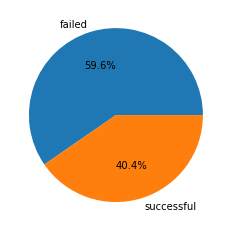

In [13]:
#Show the failure rate of projects

plt.pie(x = df['state'].value_counts(),
        labels = df['state'].value_counts().index,
        autopct='%1.1f%%')

plt.show()

In [14]:
#Convert to dummy variable:

df = pd.get_dummies(data = df,
                   columns = ['state'])

In [15]:
#We only have to keep one column:

df = df.drop('state_failed', axis = 1)

## Checking for categories of projects:

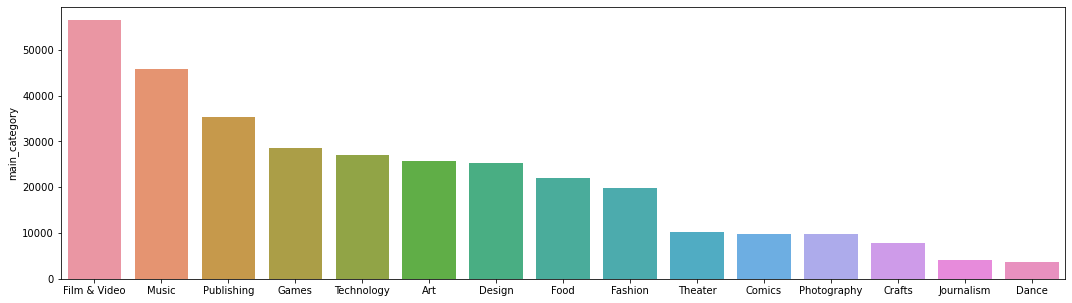

In [16]:
#Check the typical categories for projects

plt.figure(figsize = (18,5))

sns.barplot(x =  df['main_category'].value_counts().index,
            y =  df['main_category'].value_counts())

In [17]:
#Seems like project distribution is pretty balanced, a good variety of all kinds of projects except for the last few

## Checking 'currency':

In [18]:
df['currency'].value_counts()

USD    261358
GBP     29453
EUR     14357
CAD     12370
AUD      6616
SEK      1509
MXN      1411
NZD      1274
DKK       926
CHF       652
NOK       582
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

In [19]:
#Most of the projects are paid in USD, doesn't seem like an important variable

## Checking 'deadline' and 'launched':


In [20]:
df[['deadline','launched']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 1000002330 to 999988282
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   deadline  331462 non-null  object
 1   launched  331462 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [21]:
#Datatypes are classified as objects. They should be classified as time data instead

In [22]:
#Converting datatypes:

df = df.astype({'deadline':'datetime64',
                'launched':'datetime64'
               }
              )

In [23]:
#See if conversion is successful:

df[['deadline','launched']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331462 entries, 1000002330 to 999988282
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   deadline  331462 non-null  datetime64[ns]
 1   launched  331462 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 7.6 MB


### Feature engineering a new column 

Having less time before the deadline might reasonably affect project success. We will create a new column to depict that:

In [24]:
#Create a new column showing time between project launch to deadline

time_to_deadline = df['deadline'] - df['launched']
time_to_deadline[:5]

ID
1000002330   58 days 11:47:32
1000003930   59 days 19:16:03
1000004038   44 days 23:39:10
1000007540   29 days 20:35:49
1000014025   34 days 10:21:33
dtype: timedelta64[ns]

In [25]:
#Only keep the number of days to make it simpler, also as int dtype:

time_to_deadline_days = time_to_deadline.dt.days

df['Days to deadline'] = time_to_deadline_days

In [26]:
df['Days to deadline'][:5]

ID
1000002330    58
1000003930    59
1000004038    44
1000007540    29
1000014025    34
Name: Days to deadline, dtype: int64

In [27]:
#Note: Time delta information is stored in pandas in nanoseconds (10^-9).

In [28]:
#Example: 
print(time_to_deadline[1:2])
print('\t')
print(time_to_deadline[1:2].values /1000 /1000 /1000 #Convert to seconds 
                                              /60 #to Minutes
                                              /60 #to Hours
                                              /24)#to Days

ID
1000003930   59 days 19:16:03
dtype: timedelta64[ns]
	
[59]


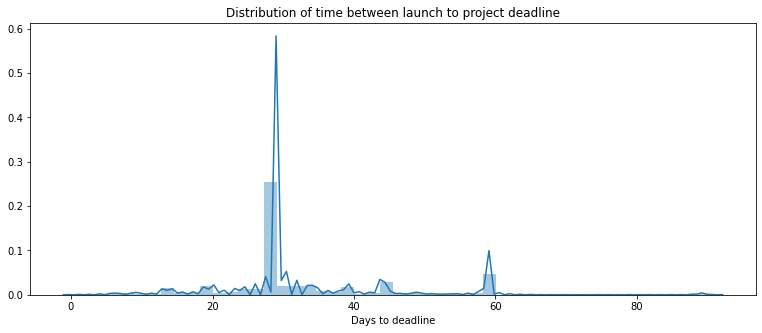

In [29]:
plt.figure(figsize = (13,5))

sns.distplot(df['Days to deadline'])

plt.title('Distribution of time between launch to project deadline')
plt.show()

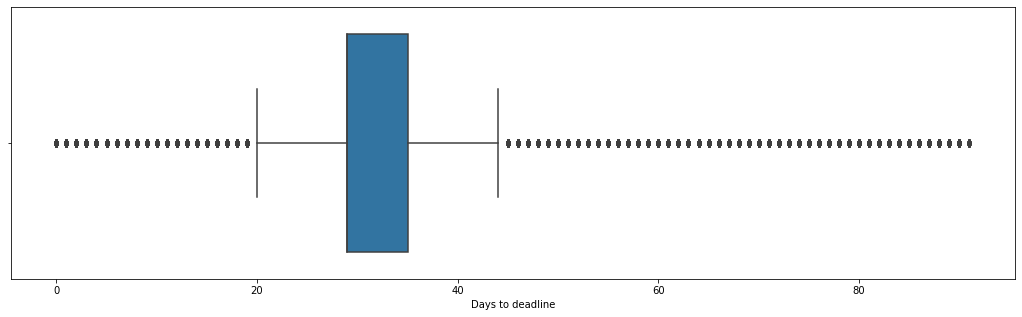

In [30]:
plt.figure(figsize=(18,5))

sns.boxplot(df['Days to deadline'])

plt.show()

In [31]:
#Definitely high variation in time to deadline, with most projects falling between 20 to 40 days

### Checking 'backers' feature

In [32]:
df['backers'].describe()

count    331462.000000
mean        116.456315
std         965.732911
min           0.000000
25%           2.000000
50%          15.000000
75%          63.000000
max      219382.000000
Name: backers, dtype: float64

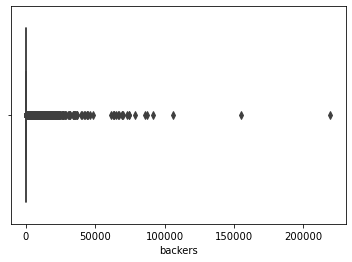

In [33]:
sns.boxplot(df['backers'])

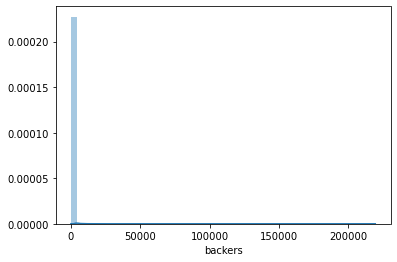

In [34]:
sns.distplot(df['backers'])

Most projects are actually very close to 0 backers - This makes sense since the failure rate is about 40%

I will also remove rows with extremely high amounts of backers (above 98th percentile), since its reasonable to assume these projects will almost certainly be successful

In [35]:
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_successful,Days to deadline
ID,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,GB,0.0,0.0,1533.95,0,58
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,15,US,100.0,2421.0,30000.00,0,59
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,3,US,220.0,220.0,45000.00,0,44
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,1,US,1.0,1.0,5000.00,0,29
1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,224,US,52375.0,52375.0,50000.00,1,34


In [36]:
df = df[df['backers'] < np.quantile(df['backers'],0.98)]

In [37]:
df['backers'].describe()

count    324831.000000
mean         57.207332
std         113.427217
min           0.000000
25%           2.000000
50%          14.000000
75%          58.000000
max         908.000000
Name: backers, dtype: float64

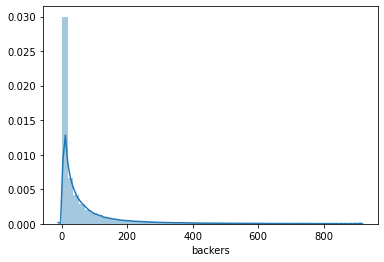

In [38]:
sns.distplot(df['backers'])

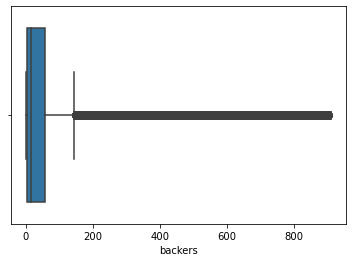

In [39]:
sns.boxplot(df['backers'])

In [40]:
# Distribution still looks very skewed, but at least it's not as extreme as before

In [41]:
df['usd_goal_real'].describe()

count    3.248310e+05
mean     4.110891e+04
std      1.119136e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      1.663614e+08
Name: usd_goal_real, dtype: float64

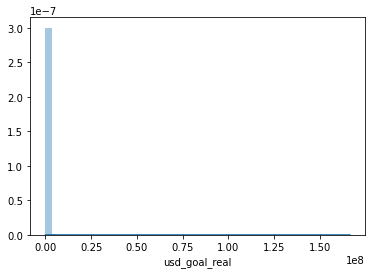

In [42]:
sns.distplot(df['usd_goal_real'])

In [43]:
#Remove both top and bottom 1 percentile: 

df = df[
         (df['usd_goal_real'] > np.quantile(df['usd_goal_real'],0.01)) & 
         (df['usd_goal_real'] < np.quantile(df['usd_goal_real'],0.99))
                        ]

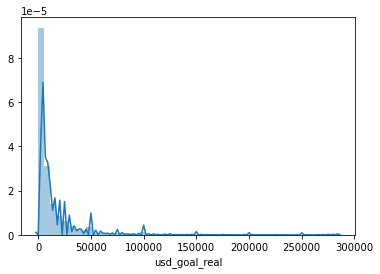

In [44]:
sns.distplot(df['usd_goal_real'])

In [45]:
df.columns

Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'state_successful',
       'Days to deadline'],
      dtype='object')

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318322 entries, 1000002330 to 999988282
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   name              318322 non-null  object        
 1   category          318322 non-null  object        
 2   main_category     318322 non-null  object        
 3   currency          318322 non-null  object        
 4   deadline          318322 non-null  datetime64[ns]
 5   goal              318322 non-null  float64       
 6   launched          318322 non-null  datetime64[ns]
 7   pledged           318322 non-null  float64       
 8   backers           318322 non-null  int64         
 9   country           318322 non-null  object        
 10  usd pledged       318322 non-null  float64       
 11  usd_pledged_real  318322 non-null  float64       
 12  usd_goal_real     318322 non-null  float64       
 13  state_successful  318322 non-null  uint8       

### Checking 'usd_pledged_real':

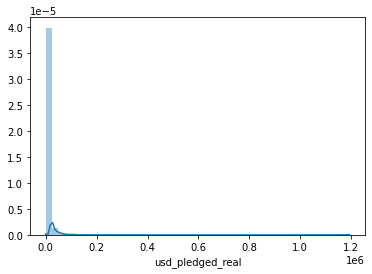

In [47]:
sns.distplot(df['usd_pledged_real'])

plt.show()

In [48]:
#Removing top 2 percentiles again:

df = df[df['usd_pledged_real'] < np.quantile(df['usd_pledged_real'], 0.98)]

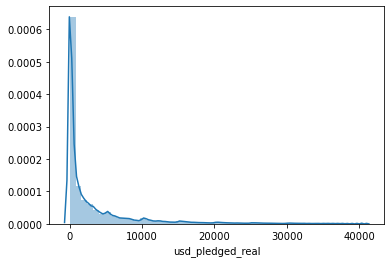

In [49]:
#Check again:

sns.distplot(df['usd_pledged_real'])

plt.show()

### Checking 'country':

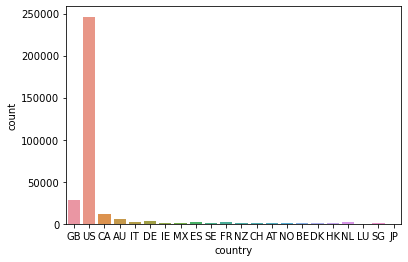

In [50]:
sns.countplot(df['country'])

In [51]:
df['country'].value_counts()

US    246241
GB     27811
CA     11550
AU      6199
DE      3187
FR      2300
IT      2241
NL      2237
ES      1748
SE      1395
MX      1380
NZ      1203
DK       860
IE       643
CH       569
NO       549
BE       488
AT       448
HK       421
SG       408
LU        54
JP        23
Name: country, dtype: int64

In [52]:
#It seems like most of the projects come from the US
#Still a decent number coming from other countries except JP and LU, so I will drop those

In [53]:
df = df[~df['country'].isin(['LU','JP'])]

### Variables picked as features so far:

Main category of project

Country of project origin

Combining launch date and deadline into 'Time before deadline'

Project goal measured in real USD value

No. of backers (Useful to provide an estimate of how many backers is needed to be successful)

### Variables not picked:

Total amount pledged measured in real USD value will not be used as this information wouldn't be available at project launch, and also estimating it is pointless as estimating a value below the goal would mean the project shouldn't succeed anyway

# Step 2.5: Scaling data

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311878 entries, 1000002330 to 999988282
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   name              311878 non-null  object        
 1   category          311878 non-null  object        
 2   main_category     311878 non-null  object        
 3   currency          311878 non-null  object        
 4   deadline          311878 non-null  datetime64[ns]
 5   goal              311878 non-null  float64       
 6   launched          311878 non-null  datetime64[ns]
 7   pledged           311878 non-null  float64       
 8   backers           311878 non-null  int64         
 9   country           311878 non-null  object        
 10  usd pledged       311878 non-null  float64       
 11  usd_pledged_real  311878 non-null  float64       
 12  usd_goal_real     311878 non-null  float64       
 13  state_successful  311878 non-null  uint8       

In [55]:
#Reset indexes to prevent some future issues with concatenation:

X = df[['main_category','Days to deadline','usd_goal_real','backers','country']].reset_index(drop = True)
y = df['state_successful'].reset_index(drop = True)

In [56]:
#We use a robust scaler because most of our variables are pretty skewed

#Robust scalers use median and IQR instead of the standard mean and S.D.

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_numerical = X.drop(['main_category','country'], axis = 1)

scaler.fit(X_numerical)

scaled_X = scaler.transform(X_numerical)

scaled_X = pd.DataFrame(scaled_X, columns = X_numerical.columns)

In [57]:
#After data scaling:

X = pd.concat([scaled_X, X[['main_category','country']]],
               join = 'outer', 
               axis = 1
             )

X.head()

,Days to deadline,usd_goal_real,backers,main_category,country
0,4.833333,-0.296407,-0.264151,Publishing,GB
1,5.000000,2.137933,0.018868,Film & Video,US
2,2.500000,3.420694,-0.207547,Film & Video,US
3,0.000000,0.000000,-0.245283,Music,US
4,-1.666667,-0.342069,0.037736,Food,US


In [58]:
#Double check the shape:

X.shape

(311878, 5)

# Step 2.5: PCA and Creating clusters

### Looking for patterns by creating clusters based on numeric data (K-Means):

In [59]:
#Attempting to obtain optimal no. of clusters k:

from sklearn.cluster import KMeans

inertias = []

for k in range(3,10):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_X)
    inertias.append(kmeans.inertia_)
    

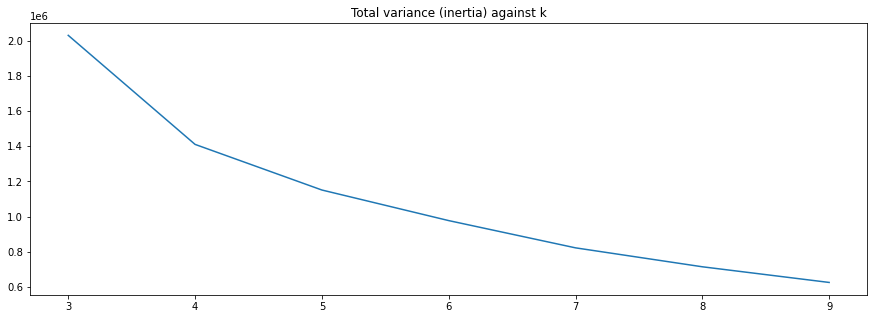

In [60]:
#Plot an inertia vs k graph to visualize the 'elbow':

plt.figure(figsize = (15,5))

sns.lineplot(x = range(3,10),
             y = inertias)

plt.title('Total variance (inertia) against k')
plt.show()

In [61]:
#Graph appears to have elbow at k=4, so I will choose that value for the clustering:

kmeans = KMeans(n_clusters = 4)

kmeans_predictions = kmeans.fit_predict(scaled_X)

#Add cluster to features table

X['Cluster (k=4)'] = kmeans_predictions

In [62]:
#Check that clusters are added:

X.head()

,Days to deadline,usd_goal_real,backers,main_category,country,Cluster (k=4)
0,4.833333,-0.296407,-0.264151,Publishing,GB,2
1,5.000000,2.137933,0.018868,Film & Video,US,2
2,2.500000,3.420694,-0.207547,Film & Video,US,2
3,0.000000,0.000000,-0.245283,Music,US,0
4,-1.666667,-0.342069,0.037736,Food,US,0


In [63]:
X['Cluster (k=4)'].value_counts()

0    226110
2     55120
3     19098
1     11550
Name: Cluster (k=4), dtype: int64

In [64]:
#Chose not to do PCA as there aren't that many variables to start with

# Step 3: Implementing models

### Before implementing models, we first encode the categorical variables:

In [65]:
#Using get_dummies would use One-hot encoding, but with high cardinality the data would end up with a high dimension

print('For One-hot encoding:')
print('No. of rows:', pd.get_dummies(X).shape[0])
print('No. of columns:', pd.get_dummies(X).shape[1])

pd.get_dummies(X).head(1)

For One-hot encoding:
No. of rows: 311878
No. of columns: 39


,Days to deadline,usd_goal_real,backers,Cluster (k=4),main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,country_HK,country_IE,country_IT,country_MX,country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,4.833333,-0.296407,-0.264151,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
#Using a binary encoder instead might help reduce the dimensionality
#This involves converting to numerical labels, then converting the numbers into binary form

import category_encoders as ce

encoder = ce.BinaryEncoder(cols = ['main_category','country','Cluster (k=4)'])

print('For binary encoding:')
print('No. of rows:', encoder.fit_transform(X).shape[0])
print('No. of columns:', encoder.fit_transform(X).shape[1])

encoder.fit_transform(X).head(1)

For binary encoding:
No. of rows: 311878
No. of columns: 17


,Days to deadline,usd_goal_real,backers,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,country_0,country_1,country_2,country_3,country_4,country_5,Cluster (k=4)_0,Cluster (k=4)_1,Cluster (k=4)_2
0,4.833333,-0.296407,-0.264151,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [67]:
#Convert categorical variables using binary encoding:

X = encoder.fit_transform(X)

In [68]:
# Splitting the data:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [69]:
%%time
#Measure how long the model takes to fit

#Try a Logistic Regression model:


from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logmodel = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = {'solver':['sag','lbfgs'],
                                      'C': [0.01,0.1,0.5,1]# Sag is gradient descent
                                     },                    # Lbfgs calculates second derivatives without actually calculating it
                        cv = 5 
                       )
logmodel.fit(X_train,y_train)


D:\Tools\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Tools\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Tools\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Tools\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
D:\Tools\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warn

Wall time: 2min 2s


D:\Tools\Anaconda\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 0.5, 1], 'solver': ['sag', 'lbfgs']})

In [70]:
print('Best parameters for Logistic Regression:', logmodel.best_params_)

Best parameters for Logistic Regression: {'C': 1, 'solver': 'sag'}


In [71]:
#Generate predictions:

logmodel_predictions = logmodel.predict(X_test)

In [72]:
%%time
#Measure how long it takes for model to fit (Averages 12-13 minutes)


#Try Support Vector Machines:

from sklearn.svm import SVC

#svc = SVC().fit(X_train,y_train) #Can't use GridSearchCV, it takes a billion years

#Generate predictions:

# svc_predictions = svc.predict(X_test)

Wall time: 0 ns


In [73]:
#Save model so I don't have to re-fit the model every time I restart the notebook

import joblib

# joblib.dump(svc, 'svc_model.joblib')

In [74]:
#Opening model from saved file:

svc = joblib.load('.\svc_model.joblib')

In [75]:
%%time

svc_predictions = svc.predict(X_test)

Wall time: 1min 38s


In [76]:
%%time
#Measure how long it takes for model to fit

#Try decision tree:

from sklearn.tree import DecisionTreeClassifier

tree = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = {'criterion':["gini", "entropy"],
                                 },
                    cv = 5 #Default 5-fold CV
                   )
tree.fit(X_train,y_train)

Wall time: 5.51 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy']})

In [77]:
print('Criterion choice for decision tree:',tree.best_params_)

Criterion choice for decision tree: {'criterion': 'entropy'}


In [78]:
#Generate predictions:

tree_predictions = tree.predict(X_test)

In [79]:
#Evaluating accuracy scores:

from sklearn.metrics import accuracy_score

print('Accuracy score for Logistic Regression:', accuracy_score(y_test,logmodel_predictions))
print('Accuracy score for Support Vector Machines:', accuracy_score(y_test,svc_predictions))
print('Accuracy score for Decision Tree:', accuracy_score(y_test,tree_predictions))

Accuracy score for Logistic Regression: 0.9164302370773416
Accuracy score for Support Vector Machines: 0.9297609794014768
Accuracy score for Decision Tree: 0.9059560823940925


# 4: Evaluating models

In [108]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
#Will use logistic regression for the next part, so we will evaluate the log model:

In [107]:
print(classification_report(y_test, logmodel_predictions))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93     63534
           1       0.92      0.85      0.89     39386

    accuracy                           0.92    102920
   macro avg       0.92      0.90      0.91    102920
weighted avg       0.92      0.92      0.92    102920



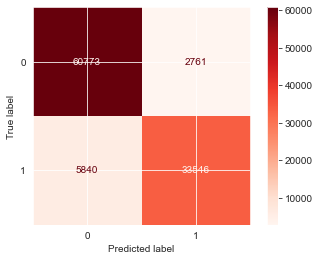

In [111]:
#Check confusion matrix:

plot_confusion_matrix(estimator = logmodel,
                      X = X_test,
                      y_true = y_test,
                      cmap = 'Reds')

#Seems like false negatives are alot more common than false positives!

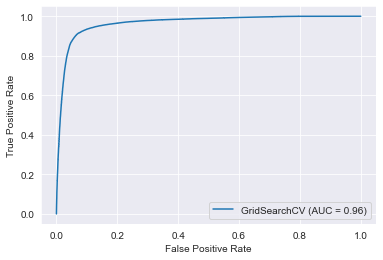

In [114]:
#See roc curve of logistic regression model:

from sklearn.metrics import plot_roc_curve

plot_roc_curve(estimator = logmodel,
               X = X_test,
               y = y_test)

plt.show()

# 5: Making a tool to estimate how many backers a project would need

The aim here is to make a simple tool to provide someone that is planning to launch a project with some idea of how many backers he would need to be successful.

In [80]:
sample = X.sample(1)

In [81]:
#Predict_proba function returns the probability of 0 and 1 as outcomes

logmodel.predict_proba(sample)

array([[0.997756, 0.002244]])

In [82]:
#To access probability that the project is successful:

print('Project probability of success:', logmodel.predict_proba(sample)[0][1])

Project probability of success: 0.0022439999668114542


### Defining a function to predict outcome

In [84]:
#First create a function that returns the success probability (using logistic regression)

def predict_project_success(data):

    #Scale data

    X_numerical = data[['Days to deadline','usd_goal_real','backers']]
    scaled_X = pd.DataFrame(scaler.transform(X_numerical), columns = X_numerical.columns)

    scaled_X

    #Cluster data

    clusters = pd.DataFrame(kmeans.predict(scaled_X), columns = ['Cluster (k=4)'])

    # Concatenate categorical and numerical variables

    X = pd.concat([scaled_X, 
                   clusters, 
                   data[['main_category','country']].reset_index(drop = True)
                  ],
                   axis = 1,
                    )

    #Encode X

    encoded_X = encoder.transform(X)

    encoded_X

    #Generate prediction probability

    return (logmodel.predict_proba(encoded_X)[0][1]) #Probability estimate that project is successful

In [102]:
#Take a sample of the data:

sample = df.sample(1)
sample

,name,category,main_category,currency,deadline,goal,launched,pledged,backers,country,usd pledged,usd_pledged_real,usd_goal_real,state_successful,Days to deadline
ID,,,,,,,,,,,,,,,
1559797982,Library Corps of Discovery: Exploring Public L...,Nonfiction,Publishing,USD,2014-05-06,10000.0,2014-04-03 16:30:09,1126.0,28,US,1126.0,1126.0,10000.0,0,32


In [103]:
#Predicted success probability of sample:

print('Predicted success probability:',predict_project_success(sample))

Predicted success probability: 0.09947853259602046


### Then define a function that generates a plot of project success probability against no. of backers:

In [87]:
#Define function to generate a plot of expected data

def plot_success_graph(days, goal, category, country, max_backers):
    
    
    '''
    This function plots a graph of an estimate of the project's success given an arbitrary amount of backers.
    
    Arguments:
    
    days: Total number of days from the project's launch to the deadline of completion.
    
    goal: The monetary goal of the project in USD.
    
    category: The category that the project falls under. Must be in: ['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts',
    'Games','Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography','Technology', 'Dance', 'Journalism']
    
    country: Country of the project's origin. Must be in: ['GB', 'US', 'CA', 'AU', 'IT', 'DE', 'IE', 'MX', 'ES', 'SE', 'FR',
       'NZ', 'CH', 'AT', 'NO', 'BE', 'DK', 'HK', 'NL', 'SG']
       
    max_backers: Maximum backers limit for model to estimate till (Model starts with 0, step size = 20).
    
    '''
    
    
    data = pd.DataFrame(columns = ['Days to deadline','usd_goal_real','main_category','country'],
                        data = [[days,goal,category,country]])
    probabilities = []
    for i in np.arange(0,max_backers,5):
        data.loc[:,'backers'] = i
        probability_success = predict_project_success(data)
        probabilities.append(probability_success)
    
    plt.figure(figsize = (20,5))
    
    sns.set_style('darkgrid')
    
    sns.lineplot(y = probabilities,
                 x = np.arange(0,max_backers,5))
    
    plt.xlabel('No. of backers', fontdict = {'fontsize':15})
    plt.xticks(np.arange(0,max_backers,step = 25))
    
    plt.ylabel('Probability of success', fontdict = {'fontsize':15})
    
    plt.title('Probability of project success by backers', fontdict = {'fontsize':15})
    
    plt.show()


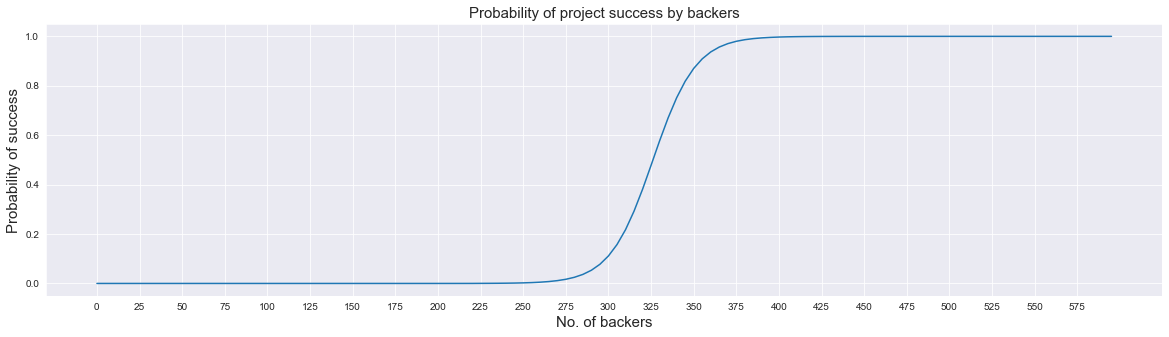

In [88]:
#Example of the function on some test data:


plot_success_graph(days = 50, 
                   goal = 49000, 
                   category = 'Games', 
                   country = 'NZ', 
                   max_backers = 600)

In [89]:
#Trying a hybrid model of k-means and k-modes for mixed attributes clustering

from kmodes.kprototypes import KPrototypes

KProt = KPrototypes(n_clusters = 8, #default clusters
                    random_state = 42,
                    )

#Algorithm runs extremely slowly, not sure why

#KProt.fit(X.sample(500), categorical = [4])

#clusters = KProt.predict(X, categorical = [4])

# Some weaknesses:

Model doesn't take into account the backer contribution, eg. different projects can have different contribution amounts for each backer. Would have been nice to have that data..